In [1]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
from cycler import cycler
from math import cos, pi

In [2]:
import openmc_source_plotter

In [3]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

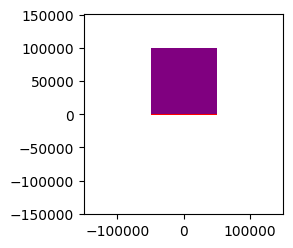

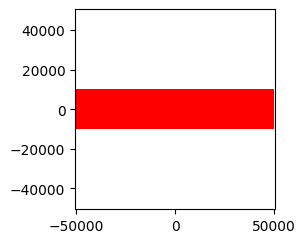

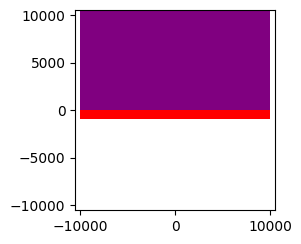

In [4]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(300100, 301100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(101100, 101100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))

In [25]:
def sim_sett(source_energy):
    #create the source
    sett = openmc.Settings()
    sett.particles = 1000000
    sett.batches = 4
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    source = openmc.Source()
    source.particle = 'neutron'
    source.energy = openmc.stats.Discrete([source_energy], [1])

    mu = openmc.stats.Uniform(cos(pi/6), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
    source.space = openmc.stats.Point((0,0,5000))
    #%matplotlib inline
    #plot = source.plot_source_direction()
    #plot.show()
    sett.source = source
    sett.export_to_xml()
    return sett

In [30]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [500,1,1]
air_mesh.lower_left = [-50000,-10000, 0]

air_mesh.upper_right = [50000,10000, 100]
mesh_filter = openmc.MeshFilter(air_mesh)
air_mesh.vertices

array([[[[-50000., -10000.,      0.],
         [-50000., -10000.,    100.]],

        [[-50000.,  10000.,      0.],
         [-50000.,  10000.,    100.]]],


       [[[-49800., -10000.,      0.],
         [-49800., -10000.,    100.]],

        [[-49800.,  10000.,      0.],
         [-49800.,  10000.,    100.]]],


       [[[-49600., -10000.,      0.],
         [-49600., -10000.,    100.]],

        [[-49600.,  10000.,      0.],
         [-49600.,  10000.,    100.]]],


       ...,


       [[[ 49600., -10000.,      0.],
         [ 49600., -10000.,    100.]],

        [[ 49600.,  10000.,      0.],
         [ 49600.,  10000.,    100.]]],


       [[[ 49800., -10000.,      0.],
         [ 49800., -10000.,    100.]],

        [[ 49800.,  10000.,      0.],
         [ 49800.,  10000.,    100.]]],


       [[[ 50000., -10000.,      0.],
         [ 50000., -10000.,    100.]],

        [[ 50000.,  10000.,      0.],
         [ 50000.,  10000.,    100.]]]])

In [31]:
#tally
def create_tally():
    tallies = openmc.Tallies()
    shine_tally = openmc.Tally(name='shine_tally')
    neutron_filter = openmc.ParticleFilter(['neutron'])
    shine_tally.scores  = ['flux']
    shine_tally.filters = [mesh_filter, neutron_filter]
    tallies.append(shine_tally)
    tallies.export_to_xml()
    return tallies

In [64]:
energies = np.array([0.1, 0.5, 0.7, 0.9, 1, 1.2, 1.5, 2, 4, 10, 200, 500, 750, 1000, 2000, 3000, 5000, 7000, 9000, 1e4, 1.5e4, 2e4, 3e4, 4e4, 5e4, 7e4, 1e5,3e5, 5e5,7e6, 8e6, 1.1e6, 1e6,2e6, 3e6, 5e6, 1e7, 1.95e7])
energies

array([1.00e-01, 5.00e-01, 7.00e-01, 9.00e-01, 1.00e+00, 1.20e+00,
       1.50e+00, 2.00e+00, 4.00e+00, 1.00e+01, 2.00e+02, 5.00e+02,
       7.50e+02, 1.00e+03, 2.00e+03, 3.00e+03, 5.00e+03, 7.00e+03,
       9.00e+03, 1.00e+04, 1.50e+04, 2.00e+04, 3.00e+04, 4.00e+04,
       5.00e+04, 7.00e+04, 1.00e+05, 3.00e+05, 5.00e+05, 7.00e+06,
       8.00e+06, 1.10e+06, 1.00e+06, 2.00e+06, 3.00e+06, 5.00e+06,
       1.00e+07, 1.95e+07])

In [65]:

df_list = []
for energy in energies:
    settings = sim_sett(energy)
    sim_tallies = create_tally()
    print(energy)
    model = openmc.model.Model(geom, mats, settings, sim_tallies)
    !rm *.h5
    results_filename = model.run()
    
    results = openmc.StatePoint(results_filename)
    flux_tally = results.get_tally(name="shine_tally")
    df = flux_tally.get_pandas_dataframe()
    df_list.append(df)
    results.close()

0.1
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #################

In [34]:
mesh_vol = 10*20
distance_x = air_mesh.vertices[:,0,0,0]
for i, energy in enumerate(energies):
    df_list[i]["Energies"] = energy

In [57]:
colors = ['maroon', 'red', 'orangered', 'chocolate', 'orange', 'gold', 'lawngreen', 'forestgreen', 'aqua', 'dodgerblue', 'navy', 'purple' ,'indigo', 'grey', 'black', 'salmon', 'saddlebrown', 'darkkhaki', 'steelblue', 'pink', 'turquoise', 'royalblue', 'olive', 'lime', 'teal']

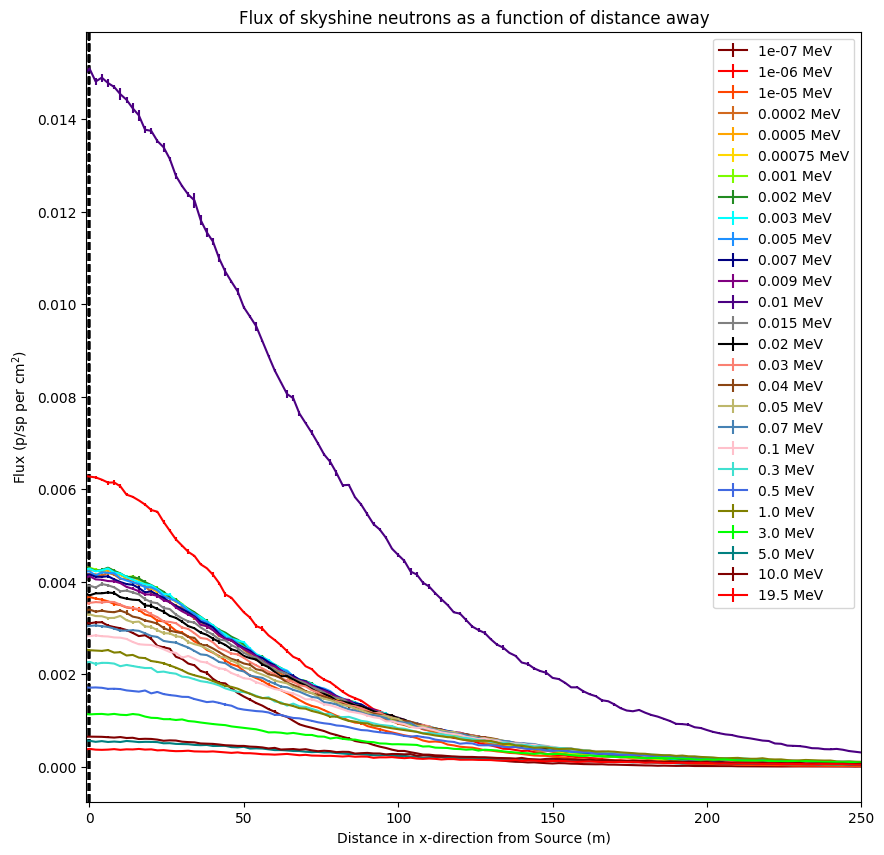

<Figure size 1000x1000 with 0 Axes>

In [58]:
max_means = []
max_stds = []

for df in df_list[:]:
    
    flux = df[df['score'] == 'flux']
    flux_mean = flux["mean"] / mesh_vol
    flux_std = flux["std. dev."] / mesh_vol
    max_means.append(np.max(flux_mean))
    max_stds.append(flux_std[np.argmax(flux_mean)])

    plt.rcParams["figure.figsize"] = (10,10)
    plt.rc('axes', prop_cycle=(cycler('color', colors))) 
    plt.errorbar(distance_x[:-1]/100, flux_mean, flux_std, label=(str(round(df["Energies"][0]/10**6,7))+ " MeV"))
    plt.legend()
    plt.xlabel("Distance in x-direction from Source (m)")
    plt.ylabel("Flux (p/sp per cm$^2$)")
    plt.axvline(x=0, ls='--', color='black')
    plt.xlim(-1, 250)
    plt.title("Flux of skyshine neutrons as a function of distance away")
    #plt.ylim(0,0.02)
    #plt.xscale('log')
    #plt.yscale('log')
   
plt.show()
plt.savefig("flux_dist.png")

In [12]:
max_stds

[4.078855665520498e-06,
 3.1049747038489355e-06,
 2.6831903976009023e-06,
 3.0031056863821637e-06,
 2.253353395728199e-06,
 3.6070812537490687e-06,
 7.019562516642258e-06,
 3.1819606611388686e-06,
 1.4616764009629562e-06,
 1.788319590891861e-06,
 7.261546275841209e-07,
 7.456980397690694e-07,
 9.76932815632911e-07]

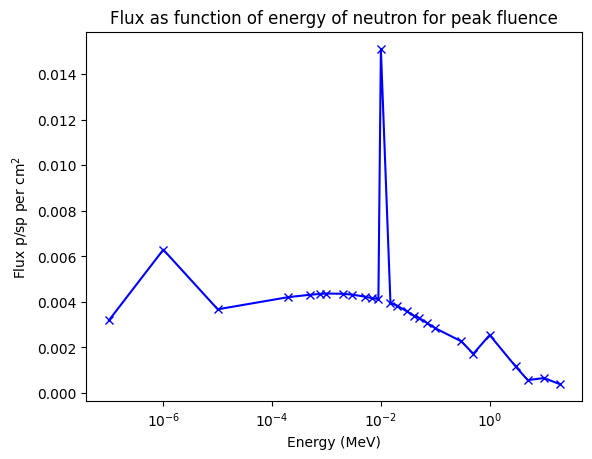

In [44]:
plt.errorbar(energies/10**6, max_means, yerr=max_stds, color='b', ls=None, marker='x')
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux p/sp per cm$^2$")
plt.title("Flux as function of energy of neutron for peak fluence")
#plt.ylim(0.0001, 0.5)
plt.xscale('log')
#plt.yscale('log')



In [63]:
rel_errs = []
for mean, std in zip(max_means, max_stds):
    per_err = (std / mean)*100
    rel_errs.append(per_err)
rel_errs

[0.6881212610345657,
 0.3648329884904585,
 1.2321250779750175,
 0.9415934442026791,
 0.9323393021966759,
 1.0221874644944642,
 0.8619993136811746,
 1.2270983863274496,
 0.7234712795778355,
 0.9065475206441324,
 0.775096681621491,
 1.0272096387123923,
 0.25016718091808116,
 0.9210990085408359,
 0.3548952095104584,
 0.894653146607311,
 0.35038758230413775,
 1.1487331628465032,
 0.7165166894875638,
 1.3052823302138041,
 0.7907372137374075,
 0.9211996025172253,
 0.40302409720724053,
 0.7045416739852224,
 1.5387133245842612,
 1.6170834871180608,
 2.1459126253325596]